# American Sign Language (ASL)
This project use DNN network with Tensorflow v1.14 framework to train. 
The topic here is about American Sign language which is the primary language used by many deaf individuals in North America. 

In this notebook, I will train a network to classify images of American Sign Language (ASL) letters. After loading, examining, and preprocessing the data, I will train the network and test its performance.


## 1. Dataset
The training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING. The folder which contains those images is datasets/asl_alphabet_train.

Because my computer is not qualified for long-time-training enough so I use a tool to get randomly 5689 images from the dataset (approximately 200 images / 1 label) to use, which is in the datasets/asl_alphabet_dev.

(Kaggle: https://www.kaggle.com/grassknoted/asl-alphabet)

In [1]:
# Import packages
import math
import numpy as np
from random import randrange

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from utils import *

import os
import cv2

# Constants
image_size = 64
num_labels = 29

At first I chose to load the images from the dataset to X_train_origin, X_test_origin, Y_train_origin, Y_test_origin using utils function I wrote separately. 

In the loading phase, I change the images's size from 200x200 to 64x64 and use train_test_split function which from sklearn.model_selection to split these images to training set and test set with the accuracy 70:30. After that, I saved these vector images and its labels to X_train_origin, X_test_origin, Y_train_origin, Y_test_origin.

In [2]:
# Loading the dataset
X_train_origin, X_test_origin, Y_train_origin, Y_test_origin = load_data()
print ()
print ("X_train_origin shape: " + str(X_train_origin.shape))
print ("Y_train_origin shape: " + str(Y_train_origin.shape))
print ("X_test_origin shape: " + str(X_test_origin.shape))
print ("Y_test_origin shape: " + str(Y_test_origin.shape))


Loading... datasets/asl_alphabet_dev: A|B|C|D|del|E|F|G|H|I|J|K|L|M|N|nothing|O|P|Q|R|S|space|T|U|V|W|X|Y|Z|
X_train_origin shape: (3982, 64, 64, 3)
Y_train_origin shape: (1, 3982)
X_test_origin shape: (1707, 64, 64, 3)
Y_test_origin shape: (1, 1707)


## 2. Visualize the training data

I sketch the figure 3 x 12 images with its label which randomly got from the dataset.

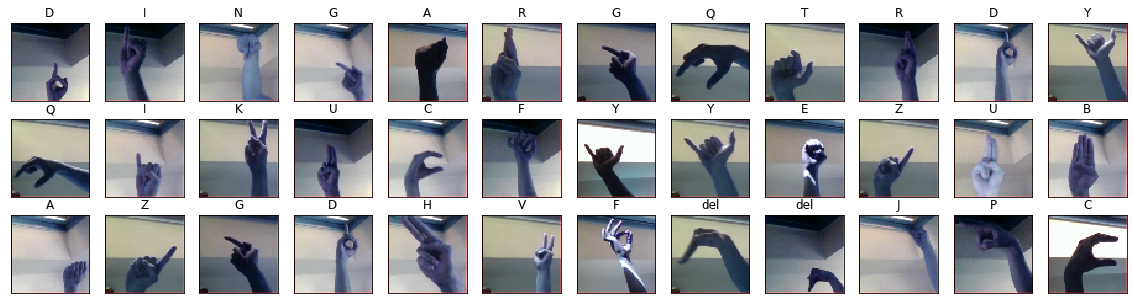

In [3]:
# Print the first several training images, along with the labels
labels = ['A','B','C','D','del','E','F','G','H','I','J','K','L','M','N','nothing','O','P','Q','R','S','space','T','U','V','W','X','Y','Z']
fig = plt.figure(figsize=(20,5))

count = 0
while count < 36:
    rannum = randrange(X_train_origin.shape[0])
    ax = fig.add_subplot(3, 12, count + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train_origin[rannum]))
    ax.set_title("{}".format(labels[Y_train_origin[0, rannum]]))
    count = count + 1
plt.show()

## 3. Handle the images in the dataset

In this phase, the training and test images will be flatten and converted to one hot matrices. The convert_to_one_hot I wrote separately in utils file.

In [4]:
# Flatten the training and test images
X_train = X_train_origin.reshape(X_train_origin.shape[0], -1).T
X_test = X_test_origin.reshape(X_test_origin.shape[0], -1).T

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_origin, 29)
Y_test = convert_to_one_hot(Y_test_origin, 29)

print ("Number of training examples = " + str(X_train.shape[1]))
print ("Number of test examples = " + str(X_test.shape[1]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples = 3982
Number of test examples = 1707
X_train shape: (12288, 3982)
Y_train shape: (29, 3982)
X_test shape: (12288, 1707)
Y_test shape: (29, 1707)


## 4. Training model

I chose DNN network using Tensorflow ver 1.14 to train. The model is **LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX**. The **SIGMOID** output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. The process is:

- Create placeholders for X and Y.
- Initializes parameters to build a neural network with tensorflow.
- Forward propagation in tensorflow.
- Compute cost

The last model implements a three-layer tensorflow neural network: **LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX** will use the above functions with these hyperparameters below:

- learning_rate (alpha) = 0.0001,
- num_epochs = 1500
- minibatch_size = 32
- lambd = 0.001 (regularization parameter)

To avoid bias, I think approximate 4k images is enough. Also, in this model I use Adam optimizer.

### 4.1 - Create placeholders
Create placeholders for `X` and `Y`.

In [5]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, name="X", shape =[n_x, None])
    Y = tf.placeholder(tf.float32, name="Y", shape =[n_y, None])
    return X, Y

### 4.2 - Initializing the parameters
Initializes parameters to build a neural network with tensorflow.

In [6]:
def initialize_parameters():
    tf.set_random_seed(5)
        
    W1 = tf.get_variable("W1", [64,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [64,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [52,64], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [52,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [29,52], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [29,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

### 4.3 - Forward propagation in tensorflow 
The function will take in a dictionary of parameters and it will complete the forward pass.

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

### 4.4 Compute cost

In [8]:
def compute_cost(A3, Y):
    """
    Computes the cost
    """
    logits = tf.transpose(A3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost

### 4.5 - Building the model

In [9]:
def model(X_train, Y_train, X_test, Y_test, regularization, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True, lambd = 0.001):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    # Initialize parameters
    parameters = initialize_parameters()
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    # Cost function: Add cost function after regularizating to tensorflow graph
    cross_entropy_cost = compute_cost(Z3, Y )
    
    # Original cost function
    if regularization == False:
        cost = cross_entropy_cost
    # Cost function using L2 Regularization
    if regularization == True:      
        weights = tf.Variable(tf.truncated_normal([X_train.shape[0], num_labels]))
        regularizer = tf.nn.l2_loss(weights)
        cost = tf.reduce_mean(cross_entropy_cost + lambd * regularizer)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per five)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 13.044384
Cost after epoch 100: 4.566943
Cost after epoch 200: 2.794419
Cost after epoch 300: 1.854914
Cost after epoch 400: 1.233203
Cost after epoch 500: 0.848641
Cost after epoch 600: 0.609014
Cost after epoch 700: 0.404597
Cost after epoch 800: 0.245731
Cost after epoch 900: 0.279059
Cost after epoch 1000: 0.099072
Cost after epoch 1100: 0.070847
Cost after epoch 1200: 0.045805
Cost after epoch 1300: 0.033652
Cost aft

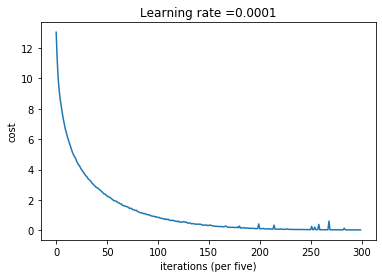

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.92852956


In [10]:
parameters = model(X_train, Y_train, X_test, Y_test, regularization = False)

The train accuracy and test accuracy is different from each other ~ 7% so I decided to add L2 regularization to reduce overfitting.

Cost after epoch 0: 542.846975
Cost after epoch 100: 29.789010
Cost after epoch 200: 2.794420
Cost after epoch 300: 1.854914
Cost after epoch 400: 1.233203
Cost after epoch 500: 0.848641
Cost after epoch 600: 0.609014
Cost after epoch 700: 0.404597
Cost after epoch 800: 0.245731
Cost after epoch 900: 0.279059
Cost after epoch 1000: 0.099072
Cost after epoch 1100: 0.070847
Cost after epoch 1200: 0.045805
Cost after epoch 1300: 0.033652
Cost after epoch 1400: 0.025448


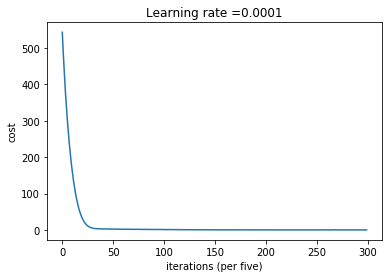

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.92852956


In [11]:
parameters = model(X_train, Y_train, X_test, Y_test, regularization = True)

Since regularization can not help reducing overfitting, I think this result can be accepted.